## Data Preprocessing

In [7]:
# Install required package
!pip install timm --quiet

In [8]:
# Import packages
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import timm
import time
import matplotlib.pyplot as plt
import tqdm
import copy

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


Using device: cuda
GPU name: NVIDIA GeForce RTX 3070 Laptop GPU


## Load and preprocess CIFAR-10

In [10]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Define training and evaluation utilities

In [11]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

def evaluate(model, test_loader, device, criterion):
    model.eval()
    correct, total = 0, 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    return accuracy, avg_loss

## DeiT Tiny2 Training loop

In [12]:
# Load DeiT Tiny and modify head for 10-class classification
model = timm.create_model('deit_tiny_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 10)
model = model.to(device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

best_acc = 0
patience = 2
trigger_times = 0
best_model_wts = copy.deepcopy(model.state_dict())
train_accs, val_accs, train_losses, val_losses = [], [], [], []

for epoch in range(20):
    start = time.time()

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = evaluate(model, test_loader, device, criterion)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/20] - Time: {time.time() - start:.2f}s")
    print(f"  Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        trigger_times = 0
        torch.save(best_model_wts, 'best_deit_tiny.pth')
        print("The best model saved.")
    else:
        trigger_times += 1
        print(f"No improvement. Trigger: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

print("Training complete. Best validation accuracy:", best_acc)


Epoch [1/20] - Time: 161.38s
  Train Acc: 90.35% | Val Acc: 93.06%
The best model saved.
Epoch [2/20] - Time: 160.20s
  Train Acc: 95.15% | Val Acc: 92.67%
No improvement. Trigger: 1/2
Epoch [3/20] - Time: 160.47s
  Train Acc: 96.66% | Val Acc: 93.76%
The best model saved.
Epoch [4/20] - Time: 161.05s
  Train Acc: 97.38% | Val Acc: 93.90%
The best model saved.
Epoch [5/20] - Time: 160.36s
  Train Acc: 97.89% | Val Acc: 94.05%
The best model saved.
Epoch [6/20] - Time: 160.90s
  Train Acc: 98.06% | Val Acc: 94.37%
The best model saved.
Epoch [7/20] - Time: 160.82s
  Train Acc: 98.38% | Val Acc: 94.22%
No improvement. Trigger: 1/2
Epoch [8/20] - Time: 160.47s
  Train Acc: 98.44% | Val Acc: 93.86%
No improvement. Trigger: 2/2
Early stopping triggered.
Training complete. Best validation accuracy: 94.37


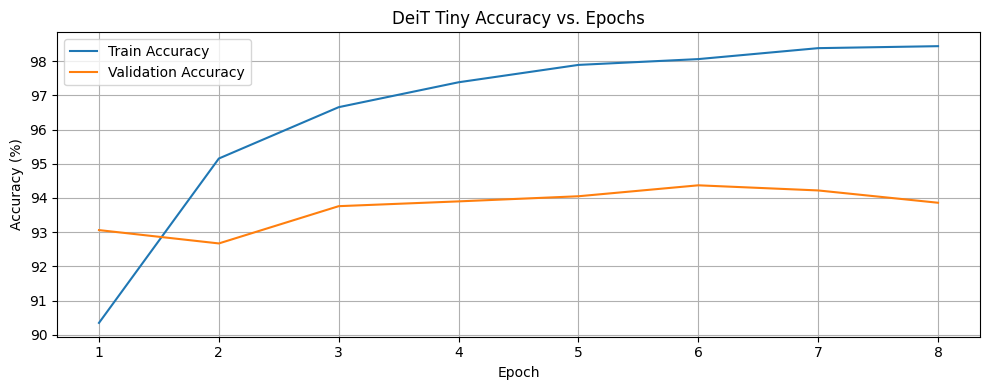

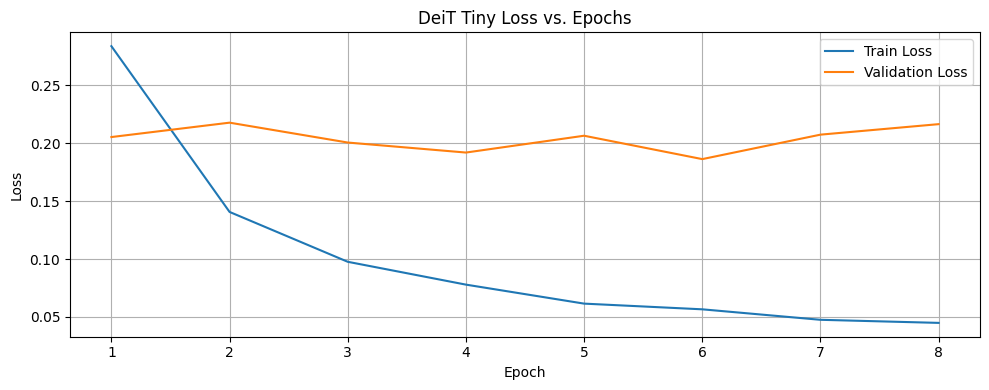

In [13]:
epochs = range(1, len(train_accs) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('DeiT Tiny Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DeiT Tiny Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



The baseline DeiT Tiny model was trained using the Adam optimizer with a learning rate of 1e-4, without weight decay or data augmentation. It reached a best validation accuracy of 94.37% at epoch 6. Training accuracy rose steadily to 98.44%, suggesting that the model learned the training data well. However, validation accuracy fluctuated slightly after epoch 6, and early stopping was triggered after two consecutive non-improving epochs. Overall, the baseline model demonstrated strong learning and generalization, but showed mild signs of overfitting in the final epochs.

## Tunning

| Hyperparameter | Description | Default / Before Value | Tuned Value | Why It Counts as Tuning |
|----------------|-------------|-------------------------|-------------|--------------------------|
| **Optimizer**  | Optimization algorithm that updates weights | `Adam` | `AdamW` | AdamW separates weight decay from learning rate, improving regularization |
| **Learning Rate** | Controls the update size during training | `1e-4` | `5e-5` | Lower value ensures more stable convergence for transformers on small data |
| **Weight Decay** | L2 penalty to prevent overfitting | `None` | `1e-4` | Helps prevent overfitting and encourages simpler models |


In [14]:
model = timm.create_model('deit_tiny_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 10)
model = model.to(device)

# Use AdamW optimizer with tuned LR and weight decay
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

# Training loop with early stopping
best_acc = 0
patience = 2
trigger_times = 0
best_model_wts = copy.deepcopy(model.state_dict())
train_accs, val_accs, train_losses, val_losses = [], [], [], []

for epoch in range(20):
    start = time.time()

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = evaluate(model, test_loader, device, criterion)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/20] - Time: {time.time() - start:.2f}s")
    print(f"  Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        trigger_times = 0
        torch.save(best_model_wts, 'best_deit_tiny_tuned.pth')
        print("The best model saved.")
    else:
        trigger_times += 1
        print(f"No improvement. Trigger: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

print("Training complete. Best validation accuracy:", best_acc)

Epoch [1/20] - Time: 160.19s
  Train Acc: 90.83% | Val Acc: 93.87%
The best model saved.
Epoch [2/20] - Time: 159.89s
  Train Acc: 96.48% | Val Acc: 95.14%
The best model saved.
Epoch [3/20] - Time: 159.68s
  Train Acc: 97.79% | Val Acc: 95.18%
The best model saved.
Epoch [4/20] - Time: 155.98s
  Train Acc: 98.31% | Val Acc: 94.94%
No improvement. Trigger: 1/2
Epoch [5/20] - Time: 154.80s
  Train Acc: 98.50% | Val Acc: 94.75%
No improvement. Trigger: 2/2
Early stopping triggered.
Training complete. Best validation accuracy: 95.18


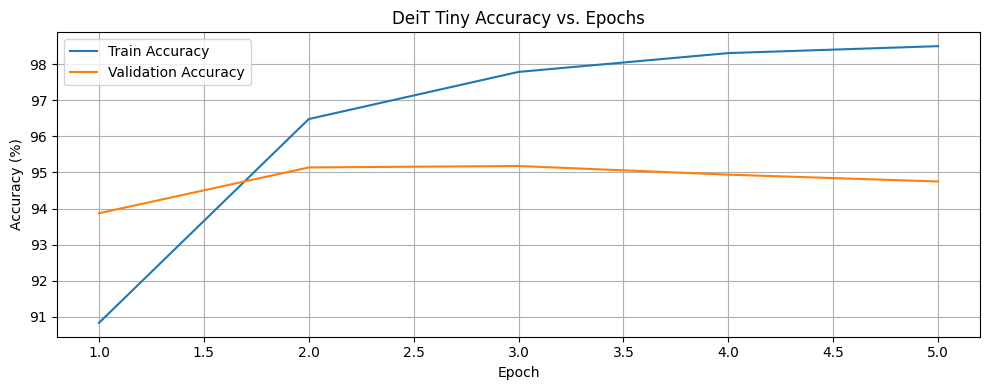

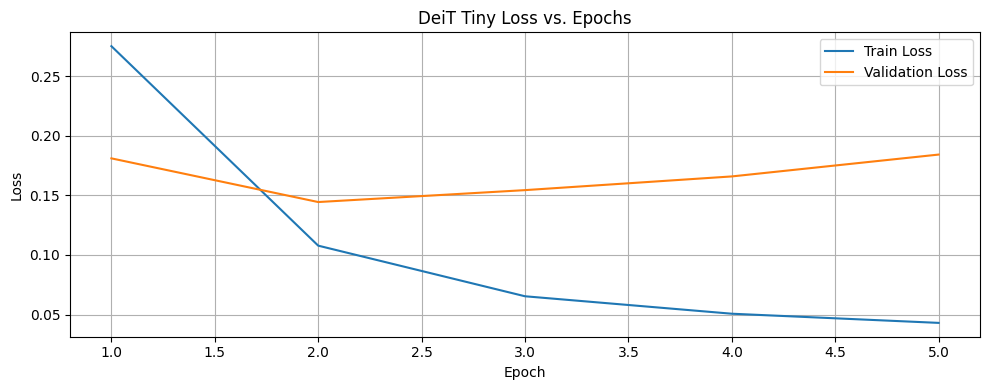

In [15]:
epochs = range(1, len(train_accs) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('DeiT Tiny Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DeiT Tiny Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

After tuning, the DeiT Tiny model used the AdamW optimizer, a lower learning rate (5e-5), and weight decay (1e-4). These changes improved training stability and generalization. The model reached a best validation accuracy of 95.18% at epoch 3 — an improvement over the baseline. Training accuracy also rose faster, reaching 98.50% by epoch 5. Early stopping was triggered after the model slightly dipped in performance, but the overall improvement in validation accuracy suggests the tuning was effective. The results highlight the benefit of tuning transformer-based models, even with subtle changes in hyperparameters.

| Aspect               | Baseline DeiT Tiny         | Tuned DeiT Tiny              |
|----------------------|----------------------------|------------------------------|
| **Optimizer**        | Adam                       | AdamW                        |
| **Learning Rate**    | 1e-4                       | 5e-5                         |
| **Weight Decay**     | None                       | 1e-4                         |
| **Early Stop Epoch** | 8                          | 5                            |
| **Best Val Accuracy**| 94.37%                     | 95.18%                       |
| **Final Train Accuracy** | 98.44%                | 98.50%                       |
| **Stability**        | Moderate (post-peak drop)  | High (early convergence)     |
| **Overfitting Risk** | Mild                       | Well-controlled              |
